# Final

CS529

Adrien Clay

Christopher Jarek

Thomas Hynes

Refat Mishuk

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from learn_car import run_learning as RunCarTraining
from evaluate_driver import evaluate_driver

def get_moving_average(series: list, window: int = 500):
    data = { 'values': series }
    df = pd.DataFrame(data)
    df['ma'] = df['values'].rolling(window).mean()
    return df['ma'].values

def plot_learning_stats(rewards, episode_target_hit_history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    rewards_rolling = get_moving_average(rewards)
    fig.suptitle(title)
    fig.set_figheight(6)
    fig.set_figwidth(12)
    ax1.plot(rewards_rolling)
    ax1.set_title("Average Rewards Per Episode (Moving Average)")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Reward")


    target_hits_rolling = get_moving_average(episode_target_hit_history)
    ax2.plot(target_hits_rolling)
    ax2.set_title("Episode Target Hits (Moving Average)")
    ax2.set_ylabel("Target Hits")
    ax2.set_xlabel("Steps")
    plt.tight_layout()
    plt.show()

## Cruise Control

### 1.1 Code Files and Implementations
Code Files:

`CCAgent.py` - Contains the agent for cruise control

`Car.py` - Contains the "Car" implementation for cruise control

`learning.py` - Basic training loop with parameter arguments, used for generating many of the included figures

`evaluate_driver.py` - Test loop for taking a learned driver and testing it with no exploration to attempt to park a car

### 1.2 Reward Implementation

The reward implementation, found in `Car.py` calculates the reward for an agent's action by using the following equation logical flow and resulting equations:

1. If the state is not in bounds, supply -10 as a static reward
2. If the state has hit the target threshold, defined as $\pm .05$ from $(0,0)$, supply a reward of +100

3. Otherwise, using the following equation:

$$
1 - .1 * (|x|^2 + |y|^2)
$$

So for example, if a state were at $(1, -1)$ the resulting reward would be calculated as:

$$
1 - .1 * (|1|**2 + |-1|^2) = .8
$$

Were the agent to step closer to, say, $(.1, -.1)$:

$$
1 - .1 * (|.1|^2 + |-.1|^2) = .998
$$

Effectively, the reward gets closer to one the closer the agents position moves towards the target $(0,0)$

However, for points further away, say $(4,4)$, we can see that the reward can grow negatively:

$$
1 - .1 * (|-4|^2 + |-4|^2) = -2.2
$$

The use of a strong negative and strong positive rewards as bonuses appears to be what triggered some learners to finally perform effectively during the training process. We initially had a lot of trouble with negative reward dominating the model, such that the model was never learning effectively as negative reward stacked up at a rate that positive reward could not keep up with. By implementating a function that is proportional to the distance from the target, we were able to lessen the effects of negative reward, and rebalance with large positive bonuses when the agent found the target.

The Q table is updated using the following method found in the slides on Reinforcement Learning:

$$
Q(S,A) = Q(S,a) + \alpha[R + \gamma Q(S\prime, A\prime) - Q(S,A)] 
$$

This can essentially be described by:

```python
new_value = entry + self.learning_rate * (reward + self.gamma * max_q - entry)
```

\pagebreak

### 1.3 - 1.5 Training Examples & Findings

#### Evaluation Method

We aggregated average episode learning rates as well as episode target hits across 10000 iterations with a max of 500 steps per episode. These are then smoothed using a moving average to observe the curve and learning effectiveness.

Finally, we use `evalute_driver.py` to have the 'driver' park the car 1000 times, over five total epochs, and then divide the total number of hits by 1000. This provides an 'accuracy' metric of sorts that can indicate to us how often the driver is hitting the target, and finally ensure that the driver hits the target effectively when starting from a randomly generated state.

Below are a series of graphical outputs pertaining to training loops. The training loop is very long, and as such only one example of training/testing is shown here, but the graphs provided are from testing the following range of values:

Sizes: 21, 41, 101

Learning Rate: Varies per size across .1, .01, .5, and .9

Gamma: .75 and .95

Epsilon: .1 and .2

Below is a table of our results:


In [3]:
df = pd.read_csv('./p1/test_results.csv')
df.drop('Unnamed: 5', axis=1, inplace=True)
df.drop('Unnamed: 6', axis=1, inplace=True)
print(df.sort_values(by=['size', 'score']))

    size  learning_rate  gamma  epsilon   score
5     21           0.01   0.95      0.1    0.20
1     21           0.01   0.75      0.1    0.50
7     21           0.01   0.95      0.2   71.30
3     21           0.01   0.75      0.2   80.90
0     21           0.10   0.75      0.1   89.00
2     21           0.10   0.75      0.2   98.50
4     21           0.10   0.95      0.1   99.90
6     21           0.10   0.95      0.2  100.00
9     41           0.01   0.75      0.1    0.10
13    41           0.01   0.95      0.1    0.20
11    41           0.01   0.75      0.2    1.10
15    41           0.01   0.95      0.2    2.30
10    41           0.10   0.75      0.2   34.00
14    41           0.10   0.95      0.2   71.30
8     41           0.10   0.75      0.1   93.80
12    41           0.10   0.95      0.1   98.60
16   101           0.10   0.95      0.2    0.20
17   101           0.01   0.95      0.2    0.20
18   101           0.01   0.75      0.2    0.30
19   101           0.10   0.75      0.1 

### Visualizing Results

Overall, the lower sized models seemed to be able to tolerate lower learning rates, and appreciate increased epsilon at .2 over .1.

For example, below shows size 21 paired with the same gamma at .75, and same epsilon at .1, however, the learning rate of .01 resulted in a massive increase in accuracy.


#### Size 21 with .01 Learning Rate

![.01 Learning Rate on Size 21](./p1/figs/s_21_l_0.01_g_0.75_e_0.1.png)



#### Size 21 with .1 Learning Rate

![.1 Learning Rate on Size 21](./p1/figs/s_21_l_0.1_g_0.75_e_0.1.png)

### Larger Spaces

For larger spaces, such as 101, smaller learning rate values were highly ineffective, resulting in dismal accuries as low as .2%. Cranking up the learning rates was necessary to see any performance out of the agent for larger models.

Below are example of this process, showing learning rates .1, .3 and .9 respectively. Even the .2 difference in learning rates results in a massive increase in accuracy

![.1 Learning Rate on Size 101](./p1/figs/s_101_l_0.1_g_0.95_e_0.1.png)

![.3 learning Rate on Size 101](./p1/figs/s_101_l_0.3_g_0.5_e_0.2.png)

![.9 learning Rate on Size 101](./p1/figs/s_101_l_0.9_g_0.5_e_0.1.png)

### Varying Episode Lengths

Below are examples and score of 4 different number of episodes and their lengths:

Total Reward: 171.87 | Total Target Hits: 381: 100%|██████████| 1000/1000 [00:37<00:00, 26.38it/s]


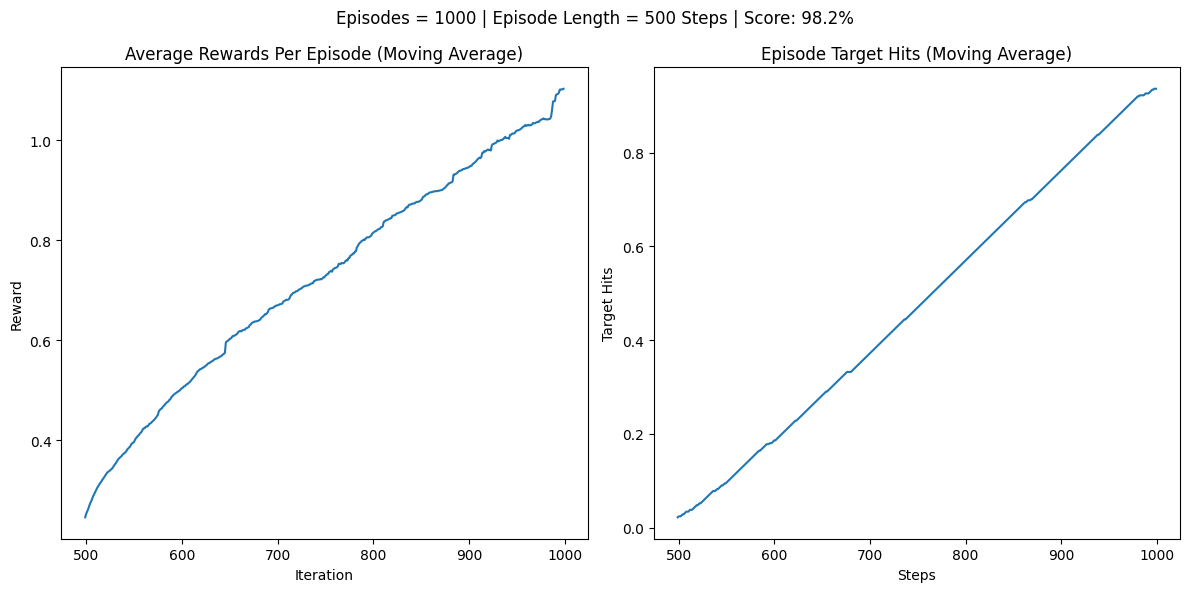

Total Reward: 138.32 | Total Target Hits: 2712: 100%|██████████| 5000/5000 [01:28<00:00, 56.63it/s]  


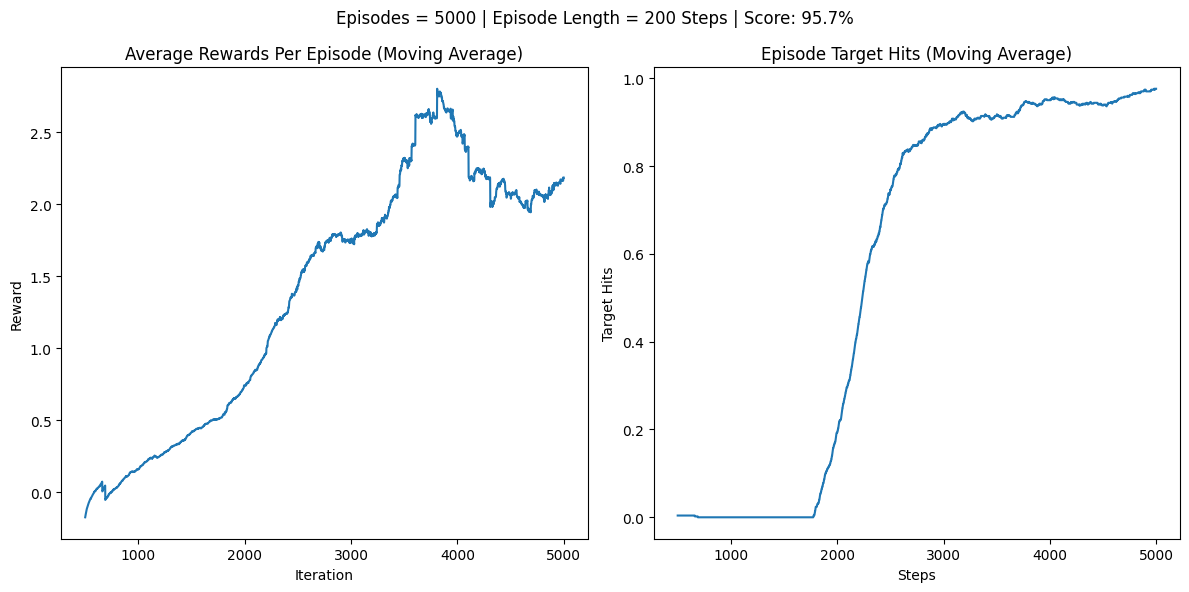

Total Reward: 135.17 | Total Target Hits: 1477: 100%|██████████| 10000/10000 [01:21<00:00, 122.22it/s]


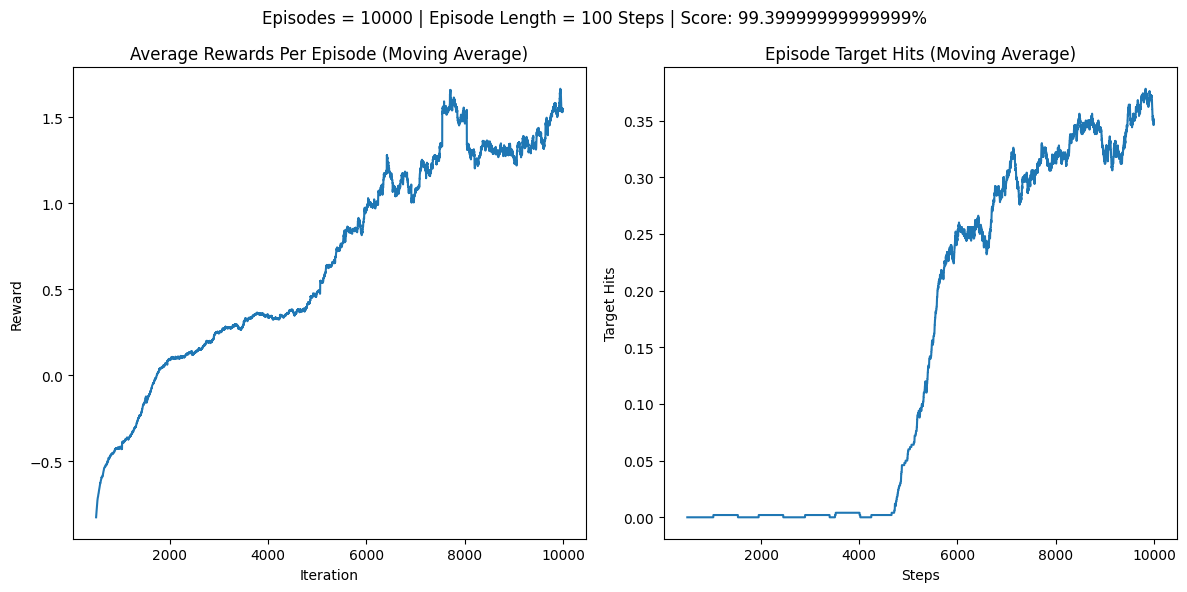

Total Reward: 133.51 | Total Target Hits: 4663: 100%|██████████| 5000/5000 [01:39<00:00, 50.47it/s] 


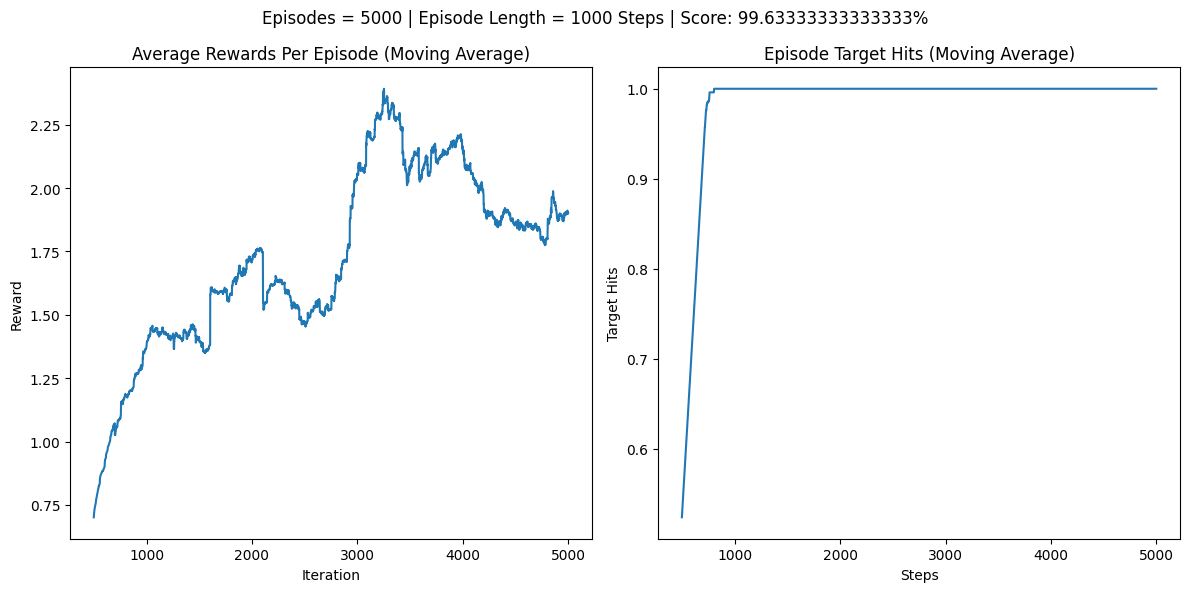

In [4]:
combinations = [(1000, 500), (5000, 200), (10000, 100), (5000, 1000)]

for episode_count, max_length in combinations:
    driver, avg_rewards, episode_target_hit_history, total_target_hits = RunCarTraining(size=101, learning_rate=.9, gamma=.5, epsilon=.1, iterations=episode_count, steps_per_episode=max_length)
    score, _ = evaluate_driver(driver, num_evals=3)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    avg_rewards_rolling = get_moving_average(avg_rewards)
    fig.suptitle(f"Episodes = {episode_count} | Episode Length = {max_length} Steps | Score: {score}%")
    fig.set_figheight(6)
    fig.set_figwidth(12)
    ax1.plot(avg_rewards_rolling)
    ax1.set_title("Average Rewards Per Episode (Moving Average)")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Reward")


    target_hits_rolling = get_moving_average(episode_target_hit_history)
    ax2.plot(target_hits_rolling)
    ax2.set_title("Episode Target Hits (Moving Average)")
    ax2.set_ylabel("Target Hits")
    ax2.set_xlabel("Steps")
    plt.tight_layout()
    plt.show()

\pagebreak

### Training Example and Visualizing Resulting Agent Trajectory

Below is an example of training and agent using the main training loop found in `learn_car.py`.

We will use some optimal parameters shown from one of the figures above.

In [5]:
driver, avg_rewards, episode_target_hit_history, total_target_hits = RunCarTraining(size=101, learning_rate=.9, gamma=.5, epsilon=.1)

Total Reward: 140.84 | Total Target Hits: 9380: 100%|██████████| 10000/10000 [02:17<00:00, 72.93it/s]


In [6]:
score, results = evaluate_driver(driver, num_evals=3)

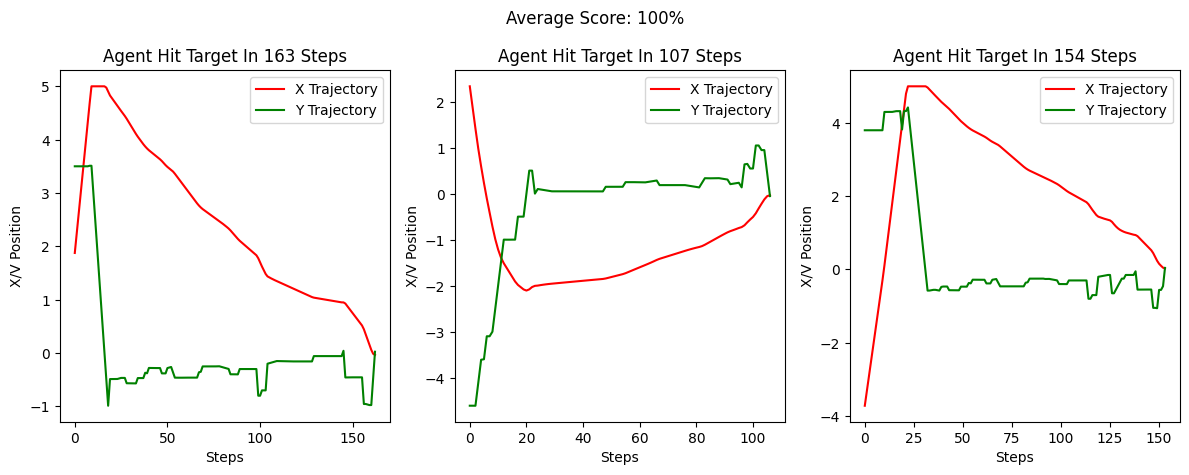

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(12)
fig.suptitle(f"Average Score: {round(score)}%")

ax1.plot(results[0]['x_trajectory'], color='red', label='X Trajectory')
ax1.plot(results[0]['v_trajectory'], color='green', label='Y Trajectory')
ax1.legend()
ax1.set_xlabel("Steps")
ax1.set_ylabel("X/V Position")
ax1.set_title(f"Agent Hit Target In {results[0]['steps']} Steps")

ax2.plot(results[1]['x_trajectory'], color='red', label='X Trajectory')
ax2.plot(results[1]['v_trajectory'], color='green', label='Y Trajectory')
ax2.set_xlabel("Steps")
ax2.set_ylabel("X/V Position")
ax2.set_title(f"Agent Hit Target In {results[1]['steps']} Steps")
ax2.legend()

ax3.plot(results[2]['x_trajectory'], color='red', label='X Trajectory')
ax3.plot(results[2]['v_trajectory'], color='green', label='Y Trajectory')
ax3.set_xlabel("Steps")
ax3.set_ylabel("X/V Position")
ax3.set_title(f"Agent Hit Target In {results[2]['steps']} Steps")
ax3.legend()


plt.tight_layout()

\pagebreak

### Shortest Path

#### 2.1 Map Abstraction
`shortestpath.py`: Contains a function to load the abstracted map from .bmp files in a specified size

We're importing the image then resizing it with the built in resize() function. Once resized,
we want to abstract the image into either #s to indicate a blocked tile, or . to indicate an open one.
We do this by first determining the tile size before iterating through the resized image which is converted into a binary map.


#### 2.2 - 2.3 Building Environment & Agent
`environment.py`: The environment containin the mapped BMP files and state logic
`agent.py`: The learning agent for the shortest path implementation

The environment works with the agent to learn which is the best path to the target.
An environment holds; the image path, map, states list, allowed states list, starting position, and agent position.
When initialized, a new environment will iterate through each map tile and create the states and allowed_states lists,
and if no target was chosen, will set the default target to be on the bottom right of the map.

This class can test a trained agent with test_agent(). This method allows a given agent to take up to 10,000 steps to find the target.


#### 2.4 Q-Learning Process
`sp_learn.py`: Primary training loop to train the agent


The reward provided to the agent per-step is the following equation:

$$
\text{distance} = \left\| \mathbf{agent\_position} - \mathbf{target} \right\|
$$

$$
\text{final} = \left( \frac{1}{1 + \text{distance}} \right) \times 10
$$


This function works well because it directly correlates with the agent distance from the target. If the agent hits the target, it will receive a static reward of +10 to encourage learning towards the target state.

\pagebreak

### 2.5 Model Evaluation

We used average rewards per episode and target hits per episode as graph-able metrics to evaluate performance. Beyond this, we also used average steps upon evaluating the agent to get a feel for how many steps each agent could reasonable hit the target in.

In [2]:
from sp_learn import run_learning as RunShortestPath

def plot_trajectory(trajectory, title):
    plt.plot(*zip(*trajectory))
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.tight_layout()
    plt.show()

### 2.6 Parameter Tuning

Below is the results table from parameter tuning across varying learning rates, gammas, epislons, and maps

In [7]:
df = pd.read_csv('sp_training_results.csv')
df.drop('Unnamed: 6', axis=1, inplace=True)
print(df)

    Map  Learning Rate  Gamma  Epsilon  Avg Steps Hit Target
0     1            0.1   0.50      0.1        117        Yes
1     1            0.1   0.50      0.2        123        Yes
2     1            0.1   0.75      0.1        117        Yes
3     1            0.1   0.75      0.2        119        Yes
4     1            0.3   0.50      0.3        119        Yes
5     1            0.3   0.50      0.2       1000         No
6     1            0.3   0.75      0.1        117        Yes
7     1            0.3   0.75      0.2        117        Yes
8     2            0.1   0.50      0.1        121        Yes
9     2            0.1   0.50      0.2        121        Yes
10    2            0.1   0.75      0.1        117        Yes
11    2            0.1   0.75      0.2        117        Yes
12    2            0.3   0.50      0.1        117        Yes
13    2            0.3   0.50      0.2        117        Yes
14    2            0.3   0.75      0.1        119        Yes
15    2            0.3  

### Results

Overall, the results seem to converge and stabilize well, with the average steps upon evaluation displayed. Ultimately, it would be good plot a few trajectories to see what the paths look like, however, below are a few graphs of the training metrics for the agent

![Map1 LR .1](./p2-figs/m_map1_l_0.1_g_0.5_e_0.1.png)

![Map2 LR .1](./p2-figs/m_map2_l_0.1_g_0.75_e_0.1.png)

![Map2 LR .3](./p2-figs/m_map2_l_0.1_g_0.75_e_0.2.png)

\pagebreak

### Varying Episode Counts & Lengths

Below is an example of varying episode counts and maximum lengths with some tuned parameters from previous experimentation

Episode Avg Reward: 1.14 | Total Target Hits: 880: 100%|██████████| 1000/1000 [00:05<00:00, 182.48it/s]


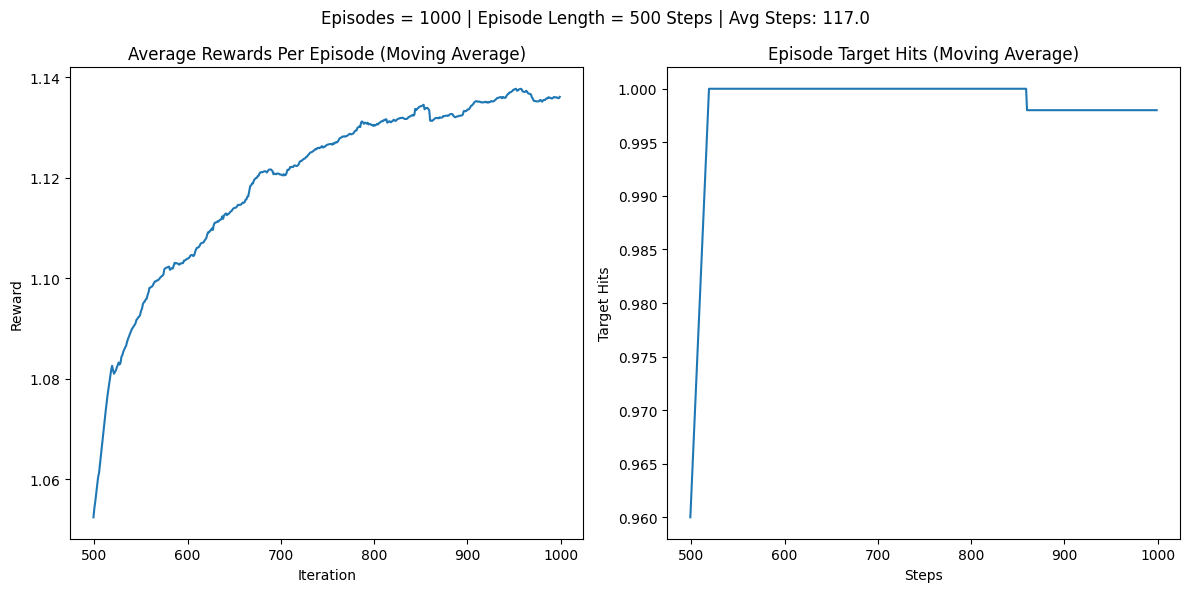

Episode Avg Reward: 0.17 | Total Target Hits: 1276: 100%|██████████| 5000/5000 [01:30<00:00, 55.52it/s] 


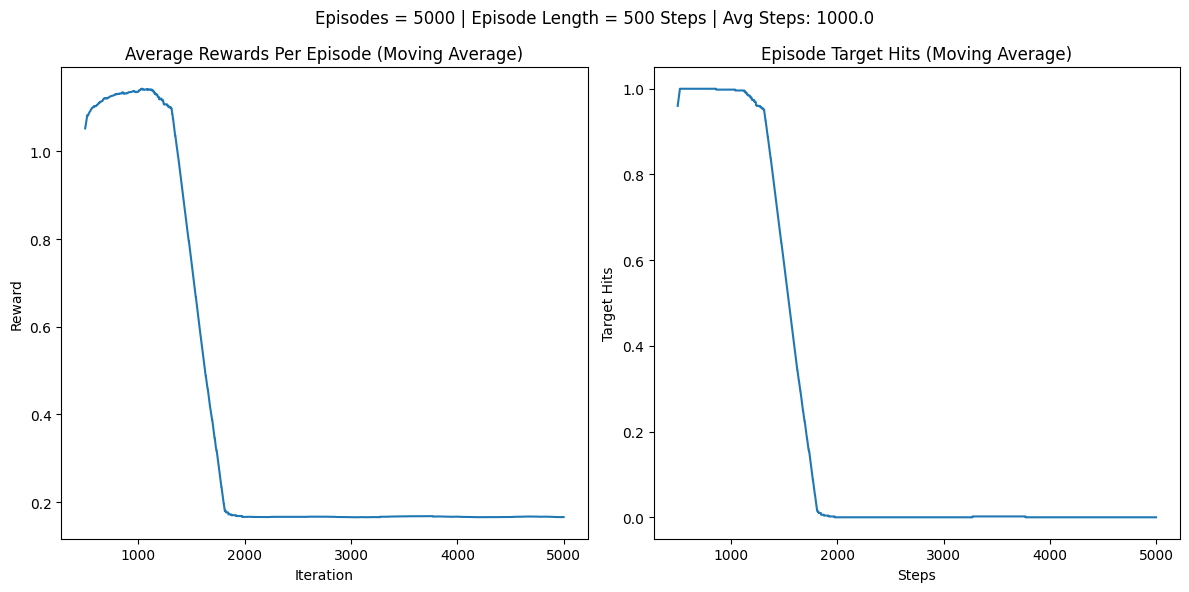

Episode Avg Reward: 0.17 | Total Target Hits: 1073: 100%|██████████| 10000/10000 [07:26<00:00, 22.37it/s]


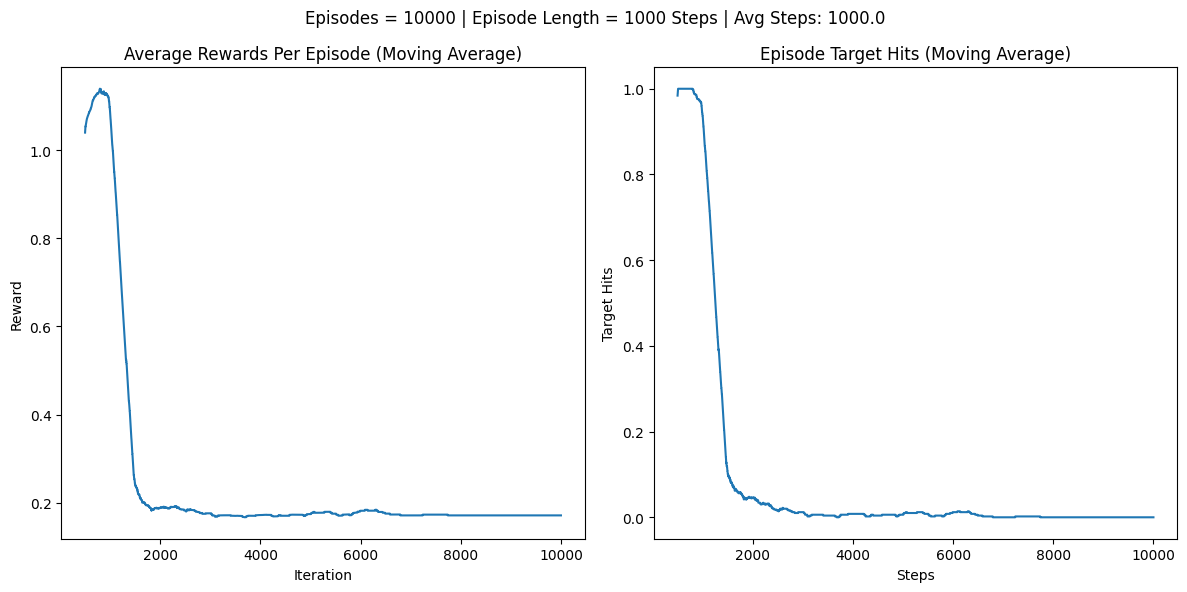

Episode Avg Reward: 0.17 | Total Target Hits: 1059: 100%|██████████| 5000/5000 [03:28<00:00, 23.98it/s]


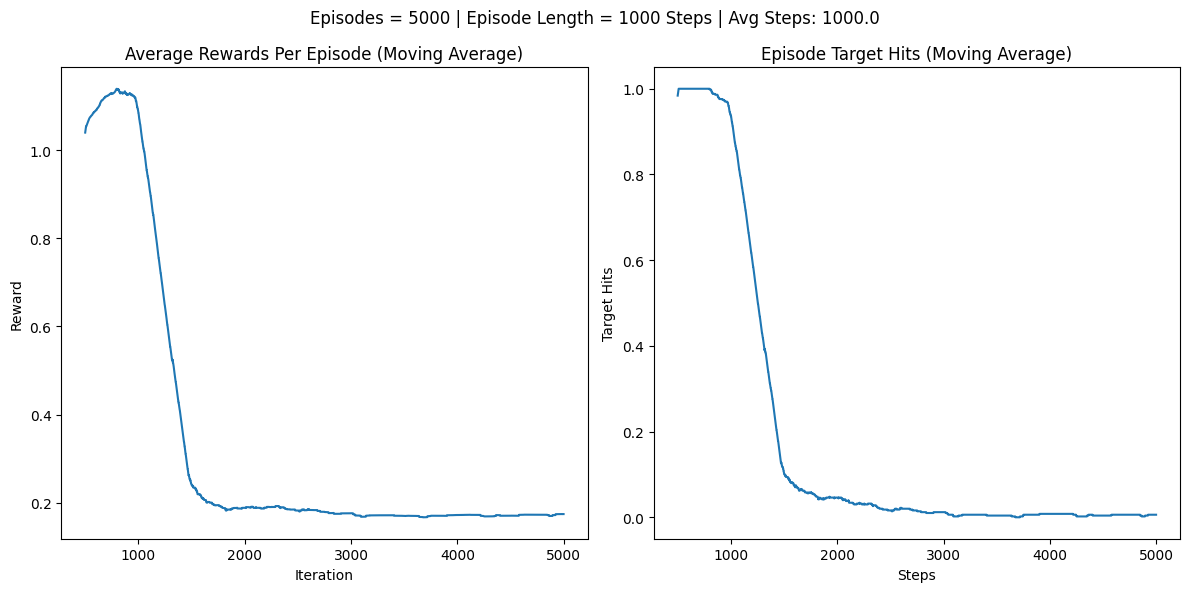

In [4]:
combinations = [(1000, 500), (5000, 500), (10000, 1000), (5000, 1000)]

for episode_count, max_length in combinations:
    agent, environment, avg_rewards, episode_target_hit_history = RunShortestPath(learning_rate=.9, gamma=.5, epsilon=.1, episode_length=episode_count, steps_per_episode=max_length)
    score, _, avg_steps = environment.evaluate_agent(agent, num_evals=1)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    avg_rewards_rolling = get_moving_average(avg_rewards)
    fig.suptitle(f"Episodes = {episode_count} | Episode Length = {max_length} Steps | Avg Steps: {avg_steps}")
    fig.set_figheight(6)
    fig.set_figwidth(12)
    ax1.plot(avg_rewards_rolling)
    ax1.set_title("Average Rewards Per Episode (Moving Average)")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Reward")


    target_hits_rolling = get_moving_average(episode_target_hit_history)
    ax2.plot(target_hits_rolling)
    ax2.set_title("Episode Target Hits (Moving Average)")
    ax2.set_ylabel("Target Hits")
    ax2.set_xlabel("Steps")
    plt.tight_layout()
    plt.show()

\pagebreak

### Agent Trajectories

Below are some examples of some agent trajectories for shortest path implementations

In [4]:
agent, environment, _, _ = RunShortestPath(image_path='map1.bmp')

Episode Avg Reward: 1.02 | Total Target Hits: 9627: 100%|██████████| 10000/10000 [01:25<00:00, 116.85it/s]


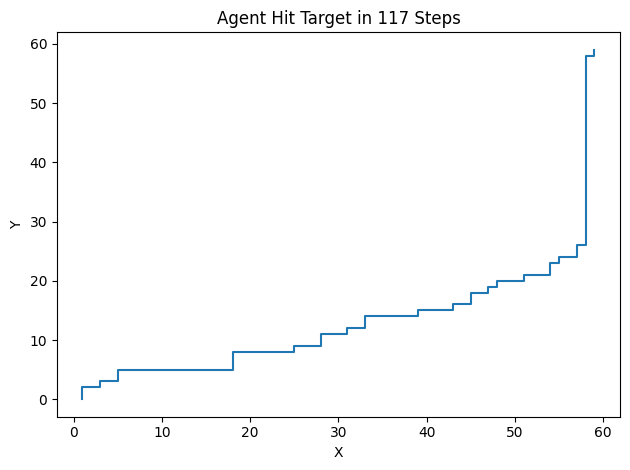

In [5]:
trajectory, steps, hit_target = environment.test_agent(agent)

plot_trajectory(trajectory, f"Agent Hit Target in {steps} Steps")

In [6]:
agent, environment, _, _ = RunShortestPath(image_path='map2.bmp')

  0%|          | 0/10000 [00:00<?, ?it/s]

Episode Avg Reward: 1.11 | Total Target Hits: 9368: 100%|██████████| 10000/10000 [02:00<00:00, 83.06it/s]


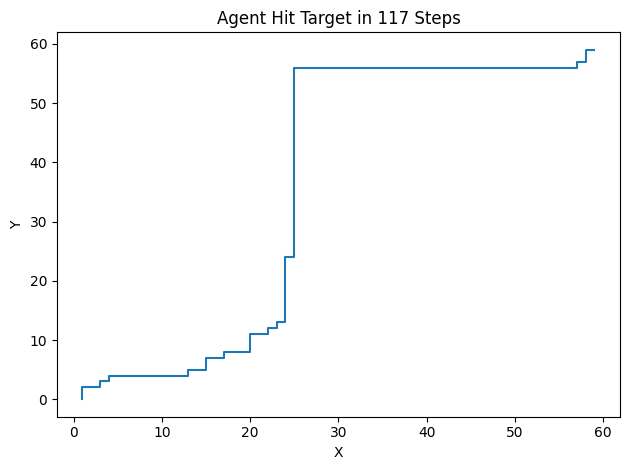

In [7]:
trajectory, steps, hit_target= environment.test_agent(agent)

plot_trajectory(trajectory, f"Agent Hit Target in {steps} Steps")